# Variational Inference and Learning in the Big Data Regime

Many real-world modelling solutions require fitting models with large numbers of data-points and parameters, which is made convenient recently through software implementing automatic differentiation, but also require uncertainty quantification. Variational inference is a generic family of tools that reformulates (Bayesian) model inference into an optimisation problem, thereby making use of modern software tools but also having the ability to give model uncertainty. This talk will motivate how variational inference works and what the state-of-the-art methods are. We will also accompany the theory with implementations on some simple probabilistic models, such as variational autoencoders (VAE). If time-permitting, we will briefly talk about some of the recent frontiers of variational inference, namely normalising flows and Stein Variational Gradient Descent.

 

💻 Content covered:

Current inference methods: maximum likelihood and Markov chain Monte Carlo

Information theory and KL divergence

Mean field variational inference

Bayesian linear regression

Monte Carlo variational inference (MCVI), reparameterisation trick and law of the unconscious statistician (LOTUS)

Example software implementations: VAE

👾 This lecture will be held online on Microsoft Teams.

🔴The event will be recorded and will be publicly available.

🎉 Attendance is FREE for members! Whether you are a student at Imperial College or not, sign up to be a member at www.icdss.club/joinus

⭐️ We encourage participants of this workshop to have looked at our previous sessions on YouTube. Prerequisites: basic understanding of Bayesian statistics

📖 A schedule of our lecture series is currently available

## Background

- Variational Inference: A Review for Statisticians: https://www.tandfonline.com/doi/full/10.1080/01621459.2017.1285773
- Auto-Encoding Variational Bayes: https://arxiv.org/pdf/1312.6114.pdf
- http://yingzhenli.net/home/en/approximateinference
- https://github.com/ethanluoyc/pytorch-vae

Consider crop yields $y$ and we have a likelihood $p(y|z)$ where $z$ are latent parameters. Suppose $z$ has some prior distribution $p(z)$, then the posterior distribution is
$$
p(z|y) \propto p(y|z)p(z) := \tilde{p}(z|y).
$$

We then want to be able to compute quantities $\mathbb{E}_{z\sim p(z|y)}[h(Z)]$, for certain functions $h$ e.g. $h(z)=z$ for the posterior mean of $Z$.

We could compute $p(z|y$) analytically if we have nice priors (conjugate priors), but this is usually not the case for most models e.g. Autoencoders with latent parameters or certain Gaussian mixture models. 

Markov chain Monte Carlo (MCMC) allows us to obtain samples from $z\sim p(z|y)$ using samplers (e.g. Hamiltonian Monte Carlo (HMC) or Metropolis-Hastings), but it could be very expensive and prohibits it from being used for the big data setting.

### Variational Inference

Variational Inference (VI)/Variational Bayes/Variational Approximation turns this problem into an optimisation problem. We now seek $q(z)$ in a space of functions $\mathcal{Q}$, instead of computing the exact $p(z|y)$, in which

$$KL(q(z) || p(z|y)) = \int \log\frac{q(z)}{p(z|y)} q(z) dq$$

is minimised. This KL denotes the KL-divergence, which is a divergence measure that looks at how close 2 distributions are to one-another. It is:

- Non-negative
- Is equal to 0 if and only if $q(z) = p(z|y)$
- Note: $KL(q(z)||p(z|y)) \neq KL(p(z|y) || q(z))$. Minimising $KL(p(z|y) || q(z))$ is the objective of Expectation Propagation, which is another method for approximating posterior distributions.

Note that maximum likelihood estimation (MLE) is done by maximising the log-likelihood, which is the same as minimising the KL divergence:

$$
\text{argmin}_{\theta} KL(\hat{p}(y|\theta^*) || p(y|\theta)) = \text{argmin}_{\theta} \frac{1}{n}\sum_{i=1}^n \log \frac{p(y_i|\hat{\theta})}{p(y_i|\theta)} = \text{argmin}_{\theta} \frac{1}{n}\sum_{i=1}^n \log \frac{1}{p(y_i|\theta)} = \text{argmax}_{\theta} \frac{1}{n}\sum_{i=1}^n \log p(y_i|\theta).
$$

**Evidence Lower-Bound**

Suppose I pose a family of posteriors $q(z)$, then

\begin{align*}
KL(q(z) || p(z|y)) = \int \log\frac{q(z)}{p(z|y)} q(z) dq &= \mathbb{E}_{z\sim q(z)}[\log q(z)] - \mathbb{E}_{z\sim q(z)}[\log p(z|y)] \\
&= \mathbb{E}_{z\sim q(z)}[\log q(z)] - \mathbb{E}_{z\sim q(z)}[\log p(z,y)] + \log p(y) \\
&= \mathbb{E}_{z\sim q(z)}[\log q(z)] - \mathbb{E}_{z\sim q(z)}[\log p(y|z)] - \mathbb{E}_{z\sim q(z)}[p(z)]  + \log p(y) \\
&=\log p(y) + \mathbb{E}_{z\sim q(z)}[\log \frac{q(z)}{p(z)}] - \mathbb{E}_{z\sim q(z)}[\log p(y|z)]  \\
&= \log p(y) + KL(q(z) || p(z)) - \mathbb{E}_{z\sim q(z)}[\log p(y|z)].
\end{align*}

Since the left term is positive and $\log p(y)$ is fixed, it is sufficient to minimise:

$$
KL(q(z) || p(z)) - \mathbb{E}_{z\sim q(z)}[\log p(y|z)].
$$

The evidence lower-bound is $ELBO(q) = \mathbb{E}_{z\sim q(z)}[\log p(y|z)] - KL(q(z) || p(z))$, which is maximised.


### Mean-Field Variational Inference

As fancy as it sounds, it just means specifying a family of posteriors $\mathcal{Q}$ such that 

$$
q(z) = \prod_{j=1}^m q_j(z_j),
$$
where $m$ is the number of parameters.

**Coordinate Ascent Variational Inference (CAVI)**
Blei et al. (2017)
![](cavi.png)

Let's look at an example (Li (2021)):
$$
y|x \sim \mathcal{N}(y; x^\intercal\theta, \sigma^2),\qquad \theta\sim\mathcal{N}(\theta; \mu_0, \Gamma_0^{-1}).
$$
This has an analytical solution
$$
p(\theta|\mathcal{D}) = \mathcal{N}(\theta; \mu,\Gamma^{-1})
$$
with
\begin{align*}
\Gamma &= \Gamma_0 + \frac{1}{\sigma^2}X^\intercal X \\
\mu &= \frac{1}{\sigma^2}(X^\intercal X + \Gamma_0)^{-1}X^Ty,
\end{align*}

where $X=(x_1,\ldots,x_n)^\intercal$ and $y=(y_1,\ldots,y_n)^\intercal$. **Let's try CAVI**:

\begin{align*}
\log q_1(\theta_1) =& \int q_2(\theta_2) \log \tilde{p}(\theta_1, \theta_2) d\theta_2\\
=& \int -\frac{1}{2}\left[(\theta_1-\mu_1)^2\Gamma_{11} + 2(\theta_1-\mu_1)\Gamma_{12}(\theta_2-\mu_2) \right]q_2(\theta_2) d\theta_2 + const \\
=& -\frac{1}{2}\left[(\theta_1-\mu_1)^2\Gamma_{11} + 2(\theta_1-\mu_1)\Gamma_{12}(\mathbb{E}_{\theta_2\sim q_2}[\theta_2]-\mu_2) \right] + const,
\end{align*}
which is Gaussian with mean and variance
$$
\tilde{\mu}_1 = \mu_1 - \Gamma_{11}^{-1}\Gamma_{12}(\mathbb{E}_{q_2}[\theta_2] - \mu_2),\qquad \tilde{\gamma}_2^{-1} = \Gamma_{11}.
$$
Similarly, you can obtain a similar expression for $q_2(\theta_2)$. For CAVI to convergence, it can be shown that $(\tilde{\mu}_1, \tilde{\mu}_2)^\intercal = \mu$, giving

$$
\tilde{\mu}_1 = \mu_1, \qquad \tilde{\mu}_2 = \mu_2.
$$

In this case, CAVI gives a Gaussian posteriors.

### Monte Carlo Variational Inference (MCVI)

For big data situations, the variational expectation term can be (1) very expensive and (2) is not available in closed form. We can also add some more complexity to the posterior instead of just having a mean-field approximation. Recall the bound:

$$
\mathcal{L}(q; p) = KL(q(z) || p(z)) - \mathbb{E}_{z\sim q(z)}[\log p(y|z)].
$$

MCVI calculates the variational expectation using Monte Carlo integration
$$
\mathbb{E}_{z\sim q(z)}[\log p(y_i|z)] \approx \frac{1}{M}\sum_{j=1}^M \log p(y_i|z^j),\qquad z^j\sim q(z).
$$
Even better, we can calculate this using mini-batches:
$$
\sum_{i=1}^n\mathbb{E}_{z\sim q(z)}[\log p(y_i|z)]  = \mathbb{E}_{S\sim \{1,\ldots,n\}}\left[\frac{n}{|S|}\sum_{i\in S} \mathbb{E}_q[\log p(y_i|z)] \right],
$$

where the inner expectation can be calculated as before. Now, to minimise $\mathcal{L}(q; p)$, we differentiate with respect to the parameters, let's call it $\theta$. Therefore, we need

\begin{align*}
\nabla_\theta \mathcal{L}(q; p) =& \nabla_\theta\left[KL(q(z) || p(z)) - \mathbb{E}_{z\sim q(z)}[\log p(y|z)] \right] \\
=& \nabla_\theta \left[ \frac{1}{M}\sum_{j=1}^M \log\frac{q(z^j)}{p(z^j)} \right] - \nabla_\theta\left[\mathbb{E}_{S\sim \{1,\ldots,n\}}\left[\frac{n}{|S|}\sum_{i\in S} \frac{1}{M}\sum_{j=1}^M \log p(y_i|z^j)\right] \right],
\end{align*}

where $z^j\sim q(z)$. We can get rid of the expectation with respect to the mini-batches and get a nice approximation for the bound for each batch $S$.

**Reparameterisation Trick/Law of the Unconcious Statistician (LOTUS)**
LOTUS basically refers to the identity:

$$
E_X[f(X)] = \int f(x) p(x) dx = \int f(g(\epsilon)) p(\epsilon) dx = E_\epsilon[f(g(\epsilon))]
$$

for $x=g(\epsilon)$, via the inverse function theorem and the change of variable theorem. The reparameterisation trick thus makes it easier to compute the bound by allowing us to sample from a simpler distribution $p(\epsilon)$ to get $q(z)$:

\begin{align*}
\nabla_\theta \mathcal{L}(q; p) =& \nabla_\theta\left[KL(q(z) || p(z)) - \mathbb{E}_{z\sim q(z)}[\log p(y|z)] \right] \\
=& \nabla_\theta\left[KL(q(z) || p(z)) - \mathbb{E}_{\epsilon}[\log p(y|g_\theta(\epsilon))] \right]\\
=& \nabla_\theta KL(q(z) || p(z)) - \mathbb{E}_{\epsilon}[\nabla_g \log p(y|g_\theta(\epsilon)) \times \nabla_\theta g_\theta(\epsilon)].
\end{align*}

Then repeat using the same MCVI integration method to approximate the variational expectation. In practice, we can also use automatic differentiation to calculate the gradients.


**Example: Variational Autoencoders (VAEs)**

Model (Taken from https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html)

![](autoencoder-architecture.png)

**(1)**
The decoder represents the likelihood $p(y|z)$, where $y$ is an image. In the upcoming example, we have

$$
\log p(y|z) = \log N(y; f_\theta(z), I) \equiv ||y - f_\theta(z)||_2^2,
$$

the MSE loss.

**(2)**
The prior is $z\sim \mathcal{N}(0, I)$. 

**(3)**
As you will see in many applications, they people only use 1 sample to calculate the variational expectation. i.e. taking $M=1$.

**(4)**
The variational distribution that we are going for is $$q(z|y) = N(g_\phi(y)[0], g_\phi(y)[1] I),$$
where the variational distribution is parameterised by the encoder network.

**(5)**
We note that we can actually analytically compute the KL divergence as they are 2 Gaussians (proceed to Wikipedia for the formula...)


## Experiments

Number of samples:  60000
0 0.07181154936552048
1 0.07108696550130844
2 0.0702378898859024
3 0.06724850833415985
4 0.07055552303791046


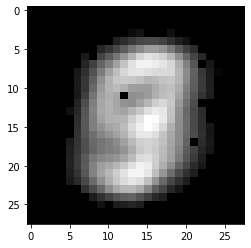

In [24]:
# from https://github.com/ethanluoyc/pytorch-vae/blob/master/vae.py

import torch
from torch.autograd import Variable
import numpy as np
import torch.nn.functional as F
import torchvision
from torchvision import transforms
import torch.optim as optim
from torch import nn
import matplotlib.pyplot as plt
from six.moves import urllib
opener = urllib.request.build_opener()
opener.addheaders = [('User-agent', 'Mozilla/5.0')]
urllib.request.install_opener(opener)

class Normal(object):
    def __init__(self, mu, sigma, log_sigma, v=None, r=None):
        self.mu = mu
        self.sigma = sigma  # either stdev diagonal itself, or stdev diagonal from decomposition
        self.logsigma = log_sigma
        dim = mu.get_shape()
        if v is None:
            v = torch.FloatTensor(*dim)
        if r is None:
            r = torch.FloatTensor(*dim)
        self.v = v
        self.r = r


class Encoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Encoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class Decoder(torch.nn.Module):
    def __init__(self, D_in, H, D_out):
        super(Decoder, self).__init__()
        self.linear1 = torch.nn.Linear(D_in, H)
        self.linear2 = torch.nn.Linear(H, D_out)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        return F.relu(self.linear2(x))


class VAE(torch.nn.Module):
    latent_dim = 8

    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder
        self._enc_mu = torch.nn.Linear(100, 8)
        self._enc_log_sigma = torch.nn.Linear(100, 8)

    def _sample_latent(self, h_enc):
        """
        Return the latent normal sample z ~ N(mu, sigma^2)
        """
        mu = self._enc_mu(h_enc)
        log_sigma = self._enc_log_sigma(h_enc)
        sigma = torch.exp(log_sigma)
        std_z = torch.from_numpy(np.random.normal(0, 1, size=sigma.size())).float()

        self.z_mean = mu
        self.z_sigma = sigma

        return mu + sigma * Variable(std_z, requires_grad=False)  # Reparameterization trick

    def forward(self, state):
        h_enc = self.encoder(state)
        z = self._sample_latent(h_enc)
        return self.decoder(z)


def latent_loss(z_mean, z_stddev):
    mean_sq = z_mean * z_mean
    stddev_sq = z_stddev * z_stddev
    return 0.5 * torch.mean(mean_sq + stddev_sq - torch.log(stddev_sq) - 1)



input_dim = 28 * 28
batch_size = 32

transform = transforms.Compose(
    [transforms.ToTensor()])
mnist = torchvision.datasets.MNIST('./', download=True, transform=transform)

dataloader = torch.utils.data.DataLoader(mnist, batch_size=batch_size,
                                         shuffle=True, num_workers=2)

print('Number of samples: ', len(mnist))

encoder = Encoder(input_dim, 100, 100)
decoder = Decoder(8, 100, input_dim)
vae = VAE(encoder, decoder)

criterion = nn.MSELoss()

optimizer = optim.Adam(vae.parameters(), lr=0.001)
l = None
for epoch in range(5):
    for i, data in enumerate(dataloader, 0):
        inputs, classes = data
        inputs, classes = Variable(inputs.resize_(batch_size, input_dim)), Variable(classes)
        optimizer.zero_grad()
        dec = vae(inputs)
        ll = latent_loss(vae.z_mean, vae.z_sigma)
        loss = criterion(dec, inputs) + ll
        loss.backward()
        optimizer.step()
        l = loss.item()
    print(epoch, l)

plt.imshow(vae(inputs).data[0].numpy().reshape(28, 28), cmap='gray')
plt.show(block=True)

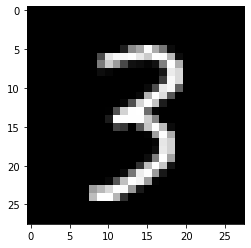

In [25]:
plt.imshow(inputs[0].numpy().reshape(28, 28), cmap='gray')

### Normalising Flows

Using a "nice" class of diffeomorphisms, one can obtain diagonal Jacobians from the diffeomorphisms, we apply the change of variables formula:
\begin{align*}
q(z_L) = q(z) \prod_{l=1}^L |\det(\nabla_{z_{l-1}} T_l(z_{l-1}))|^{-1}
\end{align*}